### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [2]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [43]:
import numpy as np 
import scipy
from scipy.stats import uniform, norm, rv_histogram
from scipy import stats
import matplotlib.pyplot as plt
from scipy import optimize
import chainconsumer
import corner
import dynesty
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture



# 1

In [3]:
data = np.load('../../../homeworks/hw_data/hw6_data_1.npy')

In [5]:
data.shape

(1000, 3)

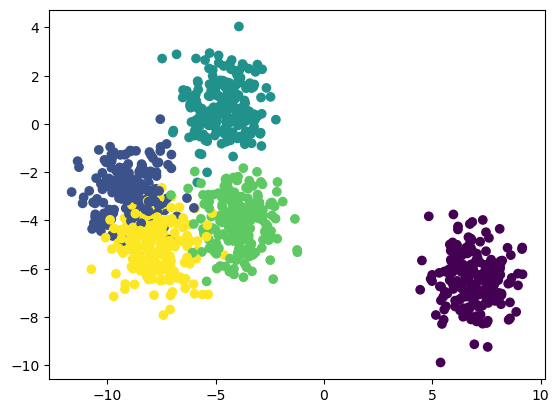

In [9]:
# LSS plotting the data with colors corresponding to their respective labels
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2])

# 2 KDE 
* grid search 5 fold to find best bandwidth. test 30 bandwidths between 0.1 and 1.0
* plot the 2D kde estimate of the dist

In [26]:
bwidths = np.linspace(0.1, 1.0, 30)
 
# LSS from lecture 14 on KDE
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwidths}, cv=K) # Try each bandwidth with K-folds
grid.fit(data[:,:2]) 
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.4724137931034482


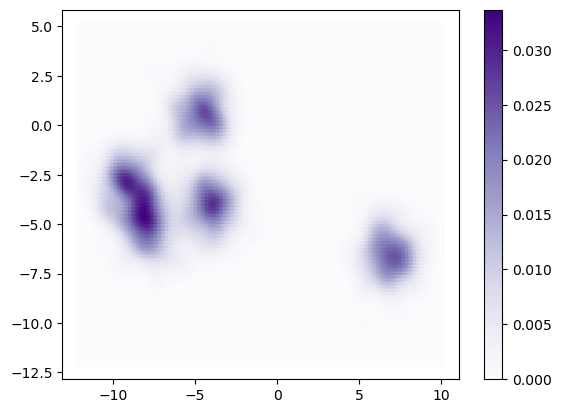

In [29]:
# LSS plotting!
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(data[:,:2])
u = np.linspace(-12, 10, 100) # LSS making mesh grid for x/y values
v = np.linspace(-12, 5, 100)
dgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(dgrid)) #evaluate the model on the grid

plt.scatter(dgrid[:,0], dgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()


# 3
* nearest neighbor density estimation

In [41]:
# LSS also from lecture 14
# Compute density with Bayesian nearest neighbors
k = 125 # LSS kneighbors ~100-150 looks close to the KDE. It fails to capture 
# LSS some of the fainter aspects of the distribution - see wispyness around left
# side clusters that is smoothed out by KNN method

nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:,:2])
dens_nbrs = nbrs.eval(dgrid) / data.shape[0]

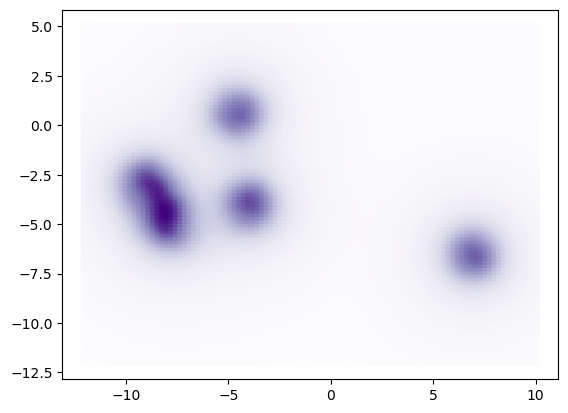

In [42]:
plt.scatter(dgrid[:,0], dgrid[:,1], c=dens_nbrs, 
            cmap="Purples", edgecolor="None")

* kneighbors ~100-150 looks close to the KDE. It fails to capture some of the 
fainter aspects of the distribution - see wispyness around left side clusters 
that is smoothed out by KNN method


# 4 GMM

In [45]:
# LSS more from Lecture 14

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(data[:,:2])

# compute the AIC and the BIC
AIC = [m.aic(data[:,:2]) for m in models]
BIC = [m.bic(data[:,:2]) for m in models]

optimal number of components according to BIC: GaussianMixture(n_components=4)


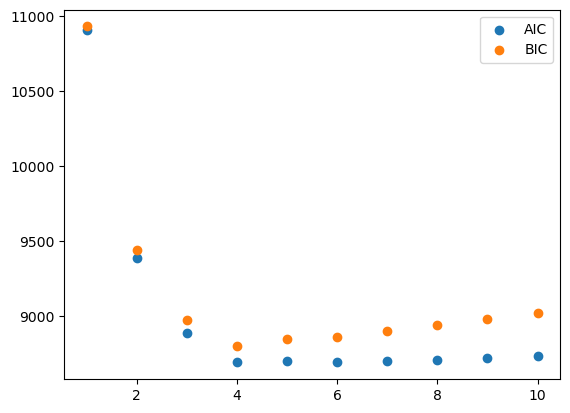

In [49]:
plt.scatter(N, AIC, label='AIC')
plt.scatter(N, BIC, label='BIC')
plt.legend()
M_best = models[np.argmin(BIC)]
print(f'optimal number of components according to BIC: {M_best}')

In [54]:
# LSS more from lecture 14

logprob = M_best.score_samples(dgrid)
pdf = np.exp(logprob)
pdf

array([5.69220488e-16, 1.95724110e-15, 6.42732482e-15, ...,
       4.87772468e-30, 2.31028940e-30, 1.03704301e-30])

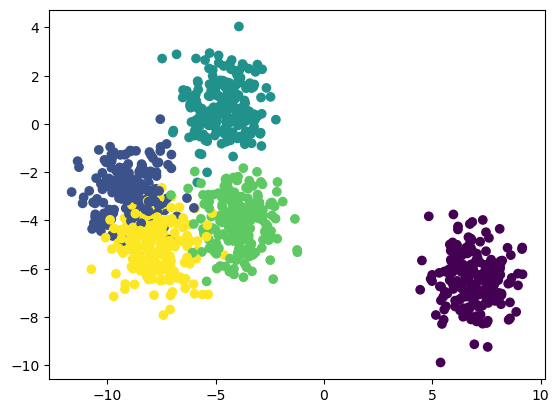

In [55]:
# LSS plotting

plt.scatter(data[:,0], data[:,1], c=data[:, 2])
